In [8]:
!pip install kaggle
!pip install wordcloud

Downloading data from Kaggle

In [9]:
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!kaggle datasets download -d wordsforthewise/lending-club

mkdir: cannot create directory ‘/root/.kaggle’: File exists
lending-club.zip: Skipping, found more recently modified local copy (use --force to force download)


In [1]:
!unzip lending-club.zip

Archive:  lending-club.zip
replace accepted_2007_to_2018Q4.csv.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [51]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display
import time

In [3]:

#columns to be used
cols= ["loan_amnt" ,'term' ,'int_rate' , 'installment' ,'grade'  ,'emp_title' ,'emp_length' ,'home_ownership' ,'annual_inc' , 'dti' ,'verification_status' ,'issue_d' ,'loan_status' ,
            'pymnt_plan' ,'desc' ,'purpose' ,'title' ,'zip_code' ,'addr_state' ,'dti' ,'fico_range_low' ,'fico_range_high' ,'tax_liens', "open_acc", "pub_rec",
        "revol_bal", "revol_util", "total_acc", "mort_acc", 'application_type']



In [4]:
accepted_loans = pd.read_csv("/content/accepted_2007_to_2018Q4.csv.gz",  low_memory=False, usecols=cols)


In [5]:
accepted_loans.drop(accepted_loans.tail(2).index, 
        inplace = True)

accepted_loans = accepted_loans[accepted_loans['application_type'] =="Individual"]

In [6]:
accepted_loans= accepted_loans[[(not i) for i in accepted_loans['loan_amnt'].isna()]]

In [7]:
accepted_loans["grade"].unique()

array(['C', 'F', 'B', 'A', 'E', 'D', 'G'], dtype=object)

In [7]:
data = accepted_loans.drop(["desc", "application_type" , "issue_d", "loan_status"], axis=1 )

In [8]:
data=data.fillna({"emp_title": "not known", "home_ownership":"not known", "emp_length": "not known", 'title':"No title", "zip_code": "000XX"})
data=data.fillna(data.mean(numeric_only=True))

# Data Analysis

In [27]:
data.head()

,loan_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,fico_range_low,fico_range_high,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,tax_liens
0,3600.0,36 months,13.99,123.03,C,leadman,10+ years,MORTGAGE,55000.0,Not Verified,n,debt_consolidation,Debt consolidation,190xx,PA,5.91,675.0,679.0,7.0,0.0,2765.0,29.7,13.0,1.0,0.0
1,24700.0,36 months,11.99,820.28,C,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,n,small_business,Business,577xx,SD,16.06,715.0,719.0,22.0,0.0,21470.0,19.2,38.0,4.0,0.0
3,35000.0,60 months,14.85,829.90,C,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,n,debt_consolidation,Debt consolidation,076xx,NJ,17.06,785.0,789.0,13.0,0.0,7802.0,11.6,17.0,1.0,0.0
4,10400.0,60 months,22.45,289.91,F,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,n,major_purchase,Major purchase,174xx,PA,25.37,695.0,699.0,12.0,0.0,21929.0,64.5,35.0,6.0,0.0
5,11950.0,36 months,13.44,405.18,C,Veterinary Tecnician,4 years,RENT,34000.0,Source Verified,n,debt_consolidation,Debt consolidation,300xx,GA,10.20,690.0,694.0,5.0,0.0,8822.0,68.4,6.0,0.0,0.0


Text(0.5, 1.0, 'Loan Grade Distribution')

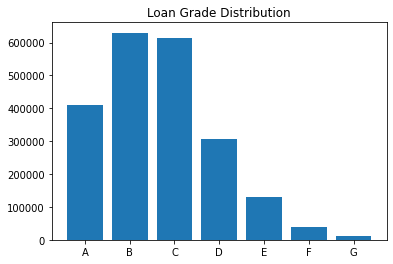

In [28]:
val=dict(accepted_loans.groupby("grade")["grade"].count())

plt.bar( val.keys(),val.values(), width=0.8 )
plt.title("Loan Grade Distribution")

KeyboardInterrupt: ignored

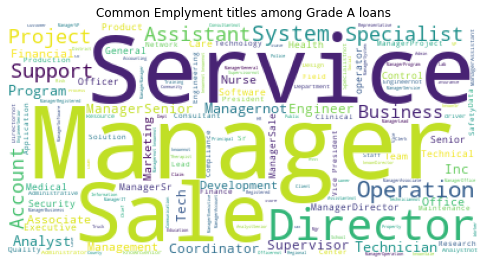

In [29]:
from wordcloud import WordCloud

figure = plt.figure()
figure.set_figheight(20)
figure.set_figwidth(20)

i=1
for grade in "ABCDEFG":
    jobs_titles= ""
    for job in data[data["grade"]==grade]['emp_title']:
        jobs_titles += job

    word_cloud = WordCloud(background_color='white', max_words=2000)
    word_cloud.generate(jobs_titles)

    
    axis= figure.add_subplot(4,2, i)
    axis.imshow(word_cloud)
    plt.title("Common Emplyment titles among Grade " + grade + " loans")
    axis.axis('off')
    i +=1

KeyboardInterrupt: ignored

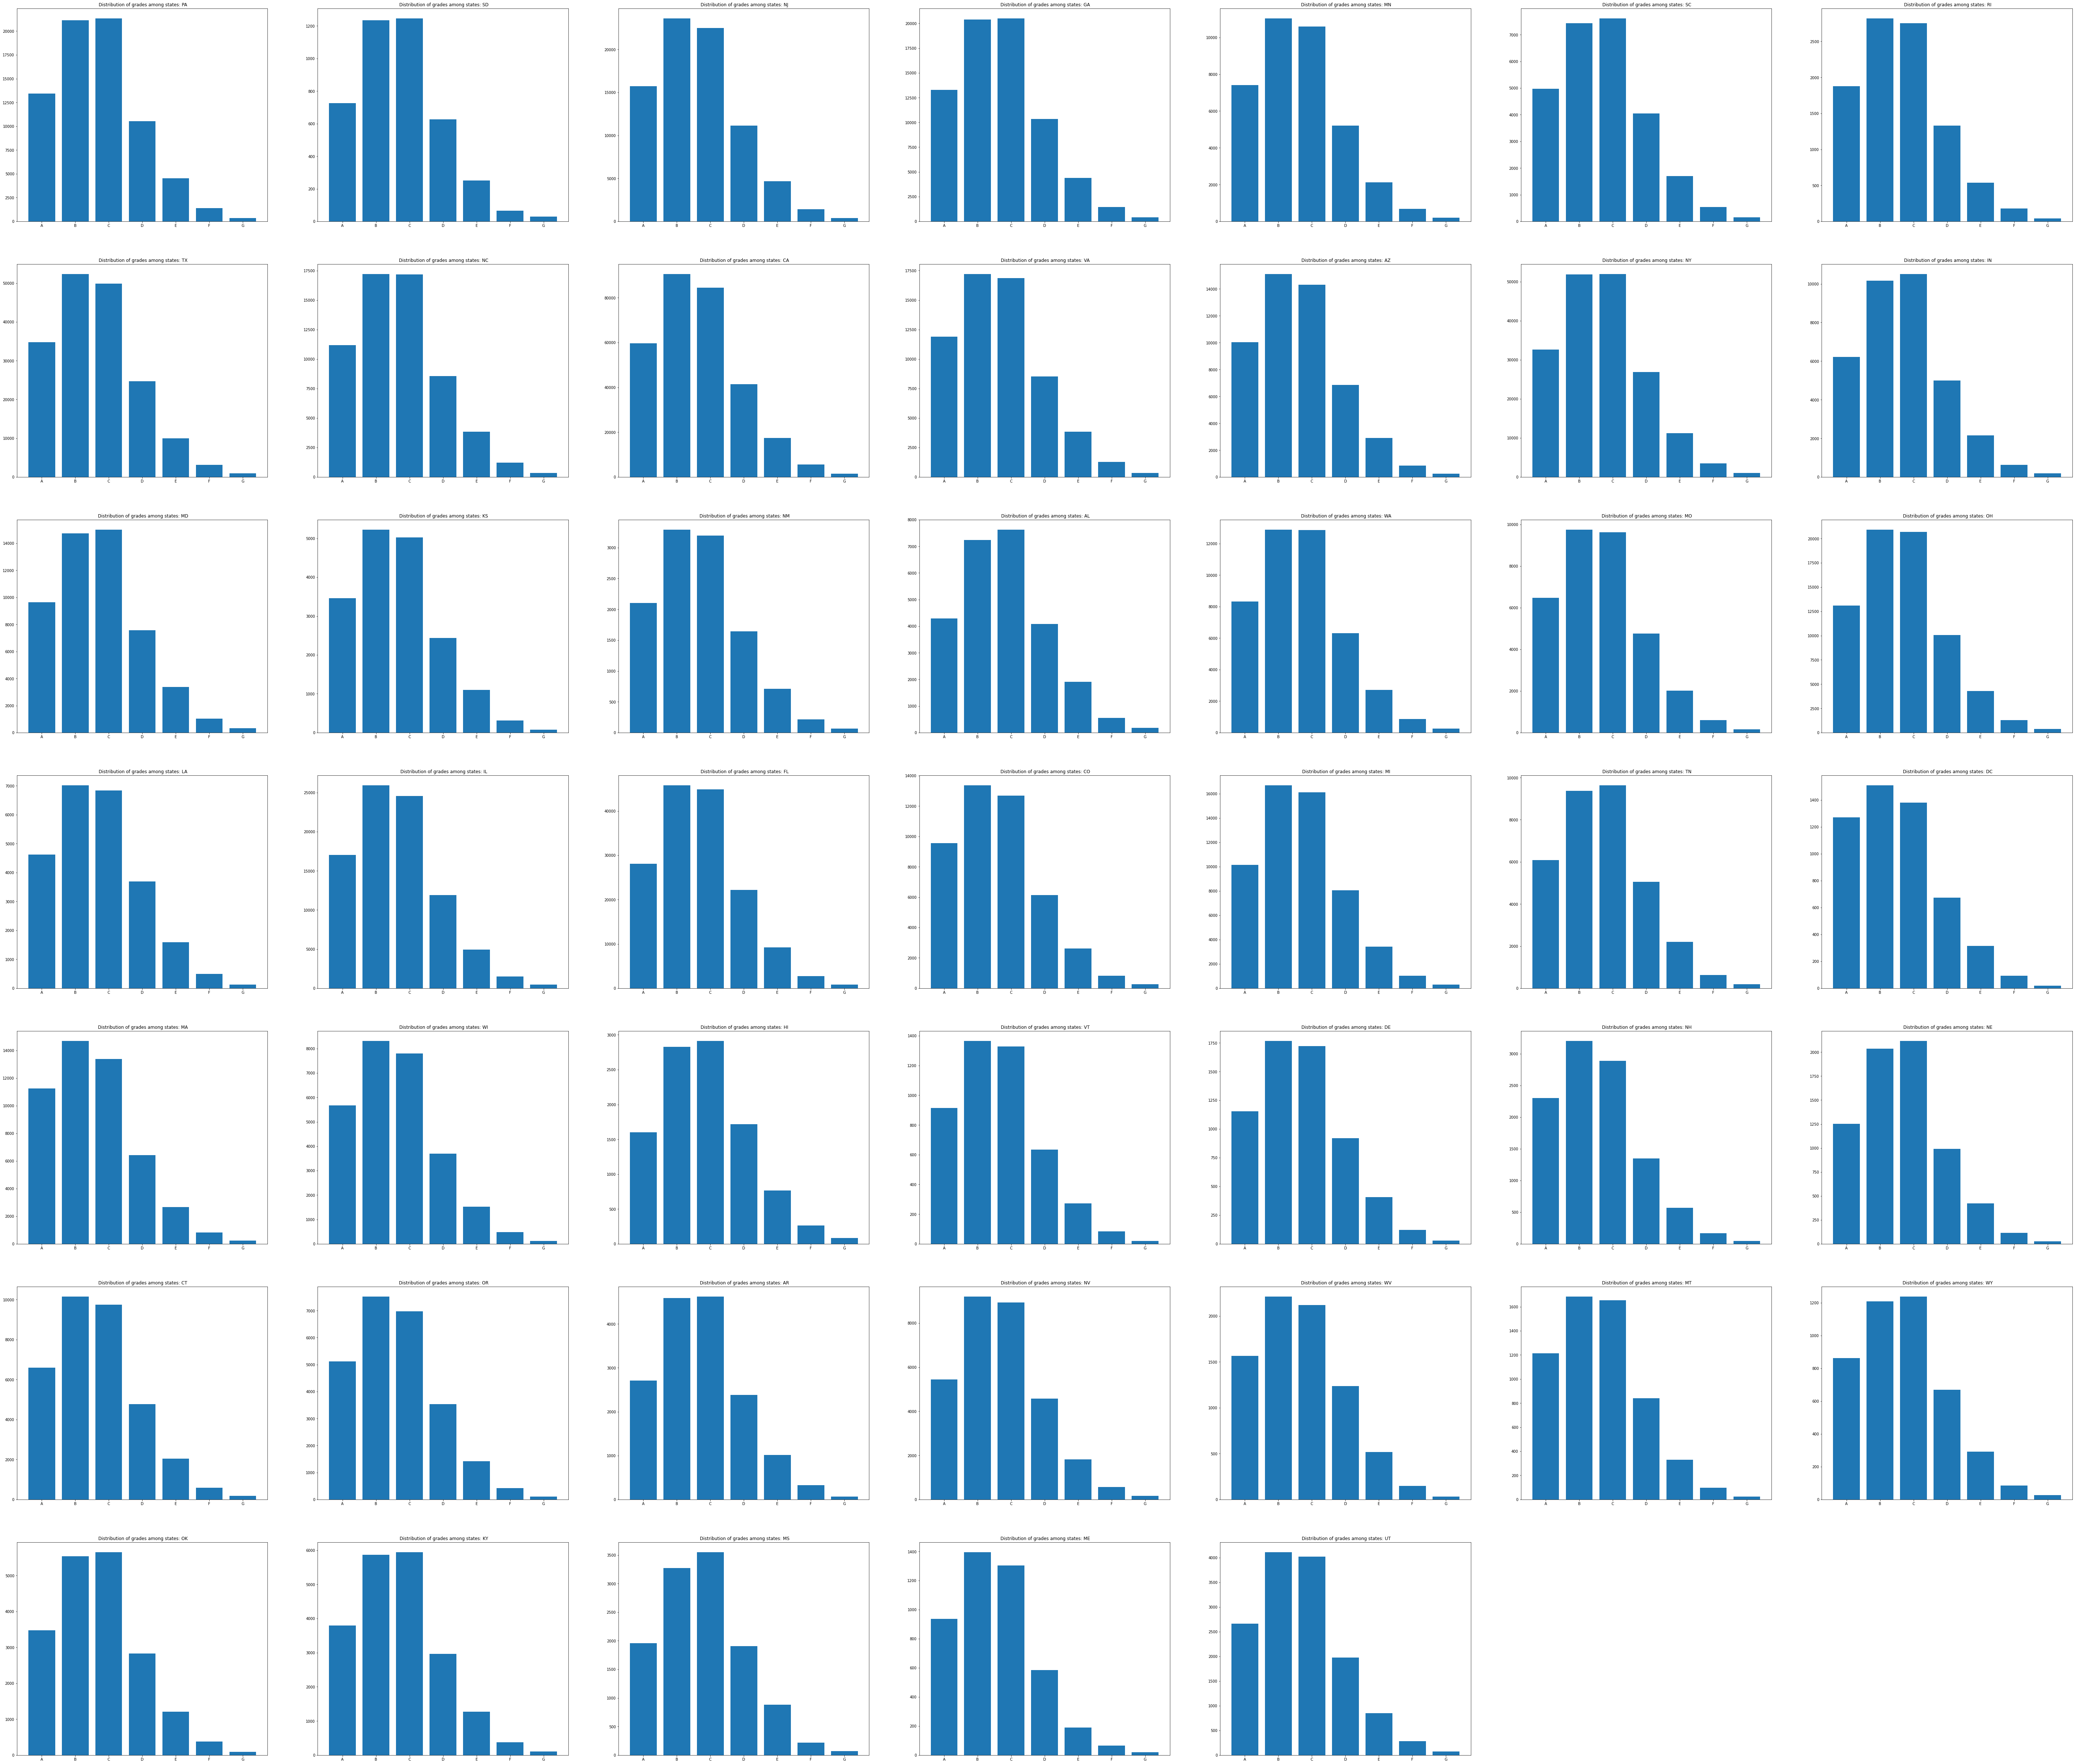

In [30]:
figure = plt.figure()
figure.set_figwidth(100)
figure.set_figheight(100)


i=1
for state in data['addr_state'].unique():
    val=dict(data[data['addr_state']==state].groupby("grade")["grade"].count())
    axis=figure.add_subplot(8,7,i)
    axis.bar( val.keys(),val.values())
    plt.title(" Distribution of grades among states: " + state)
    i+=1


In [ ]:
figure = plt.figure()
figure.set_figwidth(20)
figure.set_figheight(20)


i=1
for ownership in data['home_ownership'].unique() :
    val=dict(data[data['home_ownership']==ownership].groupby("grade")["grade"].count())
    axis=figure.add_subplot(3,2,i)
    axis.bar( val.keys(),val.values())
    plt.title(" Distribution of grade among home ownership: " + ownership )
    i+=1


#preparing Data for training

In [9]:
data['text']= data['emp_length']+ " " + data['emp_title'] + " " + data['home_ownership']+ " " + data['verification_status']+ " " + data['purpose']+ " " + data['title']+ " " + data['zip_code'] + " " + data["addr_state"] 


In [10]:
data=data.drop(['emp_length', 'emp_title', 'home_ownership', 'verification_status', 'purpose', 'title', 'zip_code' , 'addr_state' ], axis=1)
data.head()

,loan_amnt,term,int_rate,installment,grade,annual_inc,pymnt_plan,dti,fico_range_low,fico_range_high,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,tax_liens,text
0,3600.0,36 months,13.99,123.03,C,55000.0,n,5.91,675.0,679.0,7.0,0.0,2765.0,29.7,13.0,1.0,0.0,10+ years leadman MORTGAGE Not Verified debt_c...
1,24700.0,36 months,11.99,820.28,C,65000.0,n,16.06,715.0,719.0,22.0,0.0,21470.0,19.2,38.0,4.0,0.0,10+ years Engineer MORTGAGE Not Verified small...
3,35000.0,60 months,14.85,829.90,C,110000.0,n,17.06,785.0,789.0,13.0,0.0,7802.0,11.6,17.0,1.0,0.0,10+ years Information Systems Officer MORTGAGE...
4,10400.0,60 months,22.45,289.91,F,104433.0,n,25.37,695.0,699.0,12.0,0.0,21929.0,64.5,35.0,6.0,0.0,3 years Contract Specialist MORTGAGE Source Ve...
5,11950.0,36 months,13.44,405.18,C,34000.0,n,10.20,690.0,694.0,5.0,0.0,8822.0,68.4,6.0,0.0,0.0,4 years Veterinary Tecnician RENT Source Verif...


In [11]:
data.grade= pd.Categorical(data.grade)

data['grade_code']= data.grade.cat.codes

data.term= pd.Categorical(data.term)

data['term_code']= data.term.cat.codes

data.pymnt_plan= pd.Categorical(data.pymnt_plan)

data['plan_code']= data.pymnt_plan.cat.codes

In [12]:
data= data.drop('grade', axis=1)
data= data.drop('term', axis=1)
data= data.drop('pymnt_plan', axis=1)


In [15]:
data

,loan_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,tax_liens,text,grade_code,term_code,plan_code
0,3600.0,13.99,123.03,55000.0,5.91,675.0,679.0,7.0,0.0,2765.0,29.7,13.0,1.0,0.0,10+ years leadman MORTGAGE Not Verified debt_c...,2,0,0
1,24700.0,11.99,820.28,65000.0,16.06,715.0,719.0,22.0,0.0,21470.0,19.2,38.0,4.0,0.0,10+ years Engineer MORTGAGE Not Verified small...,2,0,0
3,35000.0,14.85,829.90,110000.0,17.06,785.0,789.0,13.0,0.0,7802.0,11.6,17.0,1.0,0.0,10+ years Information Systems Officer MORTGAGE...,2,1,0
4,10400.0,22.45,289.91,104433.0,25.37,695.0,699.0,12.0,0.0,21929.0,64.5,35.0,6.0,0.0,3 years Contract Specialist MORTGAGE Source Ve...,5,1,0
5,11950.0,13.44,405.18,34000.0,10.20,690.0,694.0,5.0,0.0,8822.0,68.4,6.0,0.0,0.0,4 years Veterinary Tecnician RENT Source Verif...,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260694,24000.0,12.79,543.50,95000.0,19.61,665.0,669.0,5.0,0.0,49431.0,84.4,54.0,0.0,0.0,7 years Unit Operator MORTGAGE Source Verified...,2,1,0
2260695,24000.0,10.49,515.74,108000.0,34.94,695.0,699.0,24.0,1.0,21665.0,39.0,58.0,4.0,1.0,10+ years Database Administrator MORTGAGE Not ...,1,1,0
2260696,40000.0,10.49,859.56,227000.0,12.75,705.0,709.0,5.0,0.0,8633.0,64.9,37.0,3.0,0.0,9 years Vice President MORTGAGE Verified debt...,1,1,0
2260697,24000.0,14.49,564.56,110000.0,18.30,660.0,664.0,10.0,1.0,17641.0,68.1,31.0,2.0,0.0,6 years Program Manager RENT Not Verified debt...,2,1,0


In [13]:
texts=list(data['text'])

modified_text=[]

for i in range(len(data['text'])):
    str= texts[i].replace('_', ' ')
    str= str.replace('+', '')
    str= str.replace('xx', '')
    modified_text.append(str)
data['text']= modified_text

In [14]:
tokenizer= tf.keras.preprocessing.text.Tokenizer(lower=True, split=' ', oov_token=1)

tokenizer.fit_on_texts(data['text'])

In [15]:
tokenizer.get_config()

Output hidden; open in https://colab.research.google.com to view.

In [16]:
sequence= tokenizer.texts_to_sequences(data['text'])
sequence= tf.keras.preprocessing.sequence.pad_sequences(sequence, padding='post', value=0 )
data['sequence']=list(sequence)

In [75]:
y= data['grade_code']
x=data.drop('text', axis=1)
x=x.drop('grade_code', axis=1)

In [76]:
from sklearn.model_selection import train_test_split

x_train, x_test,y_train, y_test= train_test_split(x, y, test_size=0.2, random_state=1)

x_test, x_val,y_test, y_val= train_test_split(x_test, y_test, test_size=0.5, random_state=1)


In [ ]:
train_sequence

In [77]:
train_sequence= list(x_train['sequence'])
test_sequence= list(x_test['sequence'])
val_sequence= list(x_val['sequence'])

x_train= x_train.drop('sequence', axis=1)
x_test= x_test.drop('sequence', axis=1)
x_val= x_val.drop('sequence', axis=1)

In [78]:
training_data= tf.data.Dataset.from_tensor_slices((x_train.values, train_sequence, y_train.values))
validation_data= tf.data.Dataset.from_tensor_slices((x_val.values, val_sequence,y_val.values))
test_data= tf.data.Dataset.from_tensor_slices((x_test.values, test_sequence, y_test.values))

In [79]:
training_data= training_data.batch(256)
validation_data=validation_data.batch(513)
test_data= test_data.batch(512)

#Building Model

In [80]:
from encoder_model import Encoder

class LoanGrader(tf.keras.Model):

    def __init__(self, num_encoder_layer, d_model, num_heads, dff, max_positional_encoding=34, input_dims=85267,  rate=0.1, **kwargs):
        super(LoanGrader, self).__init__(**kwargs)

        self.encoder= Encoder(num_encoder_layer, d_model, num_heads, dff, input_dims, max_positional_encoding, rate=rate )


        self.flatten= tf.keras.layers.Flatten()
        self.cancat= tf.keras.layers.Concatenate(axis=-1)

        self.batch_normalization= tf.keras.layers.BatchNormalization()
        self.dense1= tf.keras.layers.Dense(128, activation='relu')
        self.dense2= tf.keras.layers.Dense(64, activation= 'relu')
        self.dense3= tf.keras.layers.Dense(64, activation='relu')
        self.dense4=tf.keras.layers.Dense(32, activation='relu')
        self.dense5= tf.keras.layers.Dense(7, activation='softmax')

        self.class_weights=None

       
        self.optimizer= None
        
        self.variable_grouped=False

        self.epochs=0

        self.training_history= {
                                'training_loss': [],
                                'training_accuracy': [],
                                'validation_loss': [],
                                'validation_accuracy' : []
        }

    

    def call(self, X, sequence, training=False):
        """
        Performs forward pass
        """
        mask= create_padding_mask(sequence)
        x= self.encoder(sequence, mask=mask)
        x= self.flatten(x)

        X=self.batch_normalization(X, training=training)
        x= self.cancat([x, X])

        x= self.dense1(x)
        x= self.dense2(x)
        x= self.dense3(x)
        x= self.dense4(x)
        x= self.dense5(x)        

        return x

    
    def adjust_labels(self, labels, predictions):
   
        labels = tf.cast(labels, tf.int32)
        if len(predictions.shape) == len(labels.shape):
            labels = tf.squeeze(labels, [-1])
        return labels, predictions

    
    def validate_rank(self, labels, predictions, weights):
        if weights is not None and len(weights.shape) != len(labels.shape):
            raise RuntimeError(
                ("Weight and label tensors were not of the same rank. weights.shape "
                "was %s, and labels.shape was %s.") %
                (predictions.shape, labels.shape))
        if (len(predictions.shape) - 1) != len(labels.shape):
            raise RuntimeError(
                ("Weighted sparse categorical crossentropy expects `labels` to have a "
                "rank of one less than `predictions`. labels.shape was %s, and "
                "predictions.shape was %s.") % (labels.shape, predictions.shape))


    def loss(self, labels, predictions, class_weights=None, from_logits=False):
    
        # When using these functions with the Keras core API, we will need to squeeze
        # the labels tensor - Keras adds a spurious inner dimension.
        labels= tf.cast(labels, tf.int32)
        weights = tf.gather(class_weights, labels)
        

        labels, predictions = self.adjust_labels(labels, predictions)
        self.validate_rank(labels, predictions, weights)

        example_losses = tf.keras.losses.sparse_categorical_crossentropy(
            labels, predictions, from_logits=from_logits)

        if weights is None:
            return tf.reduce_mean(example_losses)
        weights = tf.cast(weights, predictions.dtype)
        return tf.math.divide_no_nan(
            tf.reduce_sum(example_losses * weights), tf.reduce_sum(weights))

    def compile(self,  optimizer, encoder_optimizer=None):
        self.optimizer= optimizer
        
        if encoder_optimizer != None:
            self.encoder_optimizer= encoder_optimizer
            
    @tf.function
    def grad(self, x_train, train_sequence, y_train):
        
        with tf.GradientTape() as tape:
            y_pred= self.call(x_train, train_sequence, training=True)
            loss_val= self.loss(y_train, y_pred, class_weights=self.class_weights)
            gradients= tape.gradient(loss_val, self.trainable_variables )
            

            self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
            
            return loss_val, y_pred

    @tf.function
    def evaluate(self, test_data, return_loss=False):
        test_loss= tf.keras.metrics.Mean()
        test_accuraccy=tf.keras.metrics.SparseCategoricalAccuracy()
        for x, sequence, y in test_data:

            y_pred= self.call(x, sequence, training=False)
            
            

            test_accuracy.update_state(y, y_pred)
            test_loss.update_state(self.loss(y, y_pred, class_weights=self.class_weights))

        if retrun_loss :
            return test_accuracy.results(), test_loss.results()
        else:
            return test_accuracy.results()
            
         

    
    def train(self, training_data, epochs, validation_data, class_weights=[1,1,1,1,1,1,1]):
        
        
        self.class_weights=class_weights

        steps_per_epoch= training_data.cardinality().numpy()
        steps_per_epoch_val= validation_data.cardinality().numpy()
        
        for epoch in range(epochs):
            
            start=time.time()
            print('Epoch ', epoch+1, ' :')
            this_epoch=display('Starting Epoch %d'%(epoch+1), display_id=True)
            train_loss = tf.keras.metrics.Mean(name='train_loss')
            train_accuracy =tf.keras.metrics.SparseCategoricalAccuracy()

            step=0
            for x,sequence, y in training_data:
                
                loss_val, y_pred =  self.grad(x, sequence, y)

                train_loss.update_state(loss_val)
                train_accuracy.update_state(y, y_pred)

                step+=1

                if step % 10== 0:
                    this_epoch.update('     {}% Compleated  | Loss {:.4f} | Accuracy {:.2f}% | Time: {} mins'.format( int((step/steps_per_epoch)*100),
                    train_loss.result(), train_accuracy.result()*100, (time.time()-start)//60))

            else:
                this_epoch.update('     {}% Compleated  | Loss {:.4f} | Accuracy {:.2f}% | Time: {} mins'.format( int((step/steps_per_epoch)*100),
                train_loss.result(), train_accuracy.result()*100, (time.time()-start)//60))
                self.epochs +=1


            self.training_history['training_loss'].append(train_loss.result())
            self.training_history['training_loss'].append(train_accuracy.result())
            
            val_start=time.time()
            step=0

            val_loss=tf.keras.metrics.Mean()
            val_accuracy=tf.keras.metrics.SparseCategoricalAccuracy()


            this_epoch_val= display('Evaluating on validation set', display_id=True)

            for x,sequence, y in validation_data:
            
                y_pred= self.call(x, sequence, training=False)

                loss_val= self.loss(y, y_pred, class_weights=self.class_weights)
                

                val_loss(loss_val)
                val_accuracy(y, y_pred)

                step+=1

                if step % 10==0:
                    this_epoch_val.update('   Validation: {}% Compleated | Loss {:.4f} | Accuracy {:.2f}% | Time: {} mins'.format(int((step/steps_per_epoch_val)*100),
                    val_loss.result(), val_accuracy.result()*100, (time.time()- val_start)//60))
            
            else:
                
                this_epoch_val.update('   Validation: {}% Compleated | Loss {:.4f} Accuracy | {:.2f}% | Time: {} mins'.format(int((step/steps_per_epoch_val)*100),
                val_loss.result(), val_accuracy.result()*100, (time.time()- val_start)//60))

                

            self.training_history['validation_loss'].append(val_loss.result())
            self.training_history['validation_accuracy'].append(val_accuracy.result())






#Training Model

In [90]:
 with tf.device('/GPU:0'): 
    model= LoanGrader(3, 128, 4, 256)


In [91]:
for x, sequence, y in training_data:
    model(x, sequence)
    break

model.summary()

Model: "loan_grader_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_9 (Encoder)          multiple                  11311616  
_________________________________________________________________
flatten_9 (Flatten)          multiple                  0         
_________________________________________________________________
concatenate_9 (Concatenate)  multiple                  0         
_________________________________________________________________
batch_normalization_9 (Batch multiple                  64        
_________________________________________________________________
dense_231 (Dense)            multiple                  526464    
_________________________________________________________________
dense_232 (Dense)            multiple                  8256      
_________________________________________________________________
dense_233 (Dense)            multiple               

In [92]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights

array([ 0.74388348,  0.48534454,  0.49873275,  1.0001332 ,  2.36852292,
        7.65179186, 26.68775332])

In [93]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=3500):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) #CustomSchedule(128, warmup_steps=500)
#encoder_optimizer=  tf.keras.optimizers.Adam(learning_rate=CustomSchedule(64, warmup_steps=500))



model.compile(optimizer=optimizer)

In [ ]:

with tf.device('/GPU:0'): 
    model.train(training_data, 10, validation_data=validation_data, class_weights=[1,1,1,1,1,1,1]) 

Epoch  1  :


'     100% Compleated  | Loss 0.4443 | Accuracy 80.73% | Time: 13.0 mins'

'   Validation: 100% Compleated | Loss 0.3185 Accuracy | 86.26% | Time: 0.0 mins'

Epoch  2  :


'     100% Compleated  | Loss 0.3661 | Accuracy 83.81% | Time: 13.0 mins'

'   Validation: 100% Compleated | Loss 0.3120 Accuracy | 86.51% | Time: 0.0 mins'

Epoch  3  :


'     100% Compleated  | Loss 0.3552 | Accuracy 84.28% | Time: 13.0 mins'

'   Validation: 100% Compleated | Loss 0.3075 Accuracy | 86.42% | Time: 0.0 mins'

Epoch  4  :


'     100% Compleated  | Loss 0.3516 | Accuracy 84.45% | Time: 13.0 mins'

'   Validation: 100% Compleated | Loss 0.3072 Accuracy | 86.55% | Time: 0.0 mins'

Epoch  5  :


'     0% Compleated  | Loss 0.3621 | Accuracy 83.28% | Time: 0.0 mins'

In [ ]:
len([model.trainable_variables] + [model.trainable_variables] )